In [1]:
# !pip install -q qiskit
# !pip install -q pyscf
# !pip install -q qiskit-aqua
# !pip install pylatexenc


In [2]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer,IBMQ
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from myvqe import VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType
from qiskit.algorithms.optimizers import SPSA,CG
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian


In [3]:
import sys
import math
from qiskit import Aer
import os
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeJakarta
from qiskit.ignis.mitigation import MeasurementFilter,CompleteMeasFitter
from qiskit.circuit.library import EfficientSU2,TwoLocal

device_backend = FakeJakarta()
seed =17
vqe_energies = []
hf_energies = []


exact_energies = []
noisy_vqe_energies = []
noisy_mitigation_vqe_energies = []
compression_exact_energies = []
compression_noisy_vqe_energies = []
compression_noisy_mitigation_vqe_energies = []



exact_energies_opt = []
noisy_vqe_energies_opt = []
noisy_mitigation_vqe_energies_opt = []
compression_exact_energies_opt = []
compression_noisy_vqe_energies_opt = []
compression_noisy_mitigation_vqe_energies_opt = []

distances = np.arange(0.5,4.5,0.5)


def get_fixing_parameters(weight,regu_val = math.pi  ):
    t1 = np.floor(weight/regu_val) 
    t2 = weight % (regu_val)
    t1[t2>regu_val/2] = t1[t2>regu_val/2] + 1
    t2[t2>regu_val/2] = regu_val/2 - t2[t2>regu_val/2]
    fixing_paras = t1*regu_val
    return fixing_paras


def get_fixing_abs(weight,fix_para):
    fixing_abs= np.abs(weight-fix_para)
    return fixing_abs

def compression(weight,percent=70):
    fixing_para = get_fixing_parameters(weight)
    weight_temp = get_fixing_abs(weight,fixing_para)
    percentile = np.percentile(weight_temp, percent)  # get a value for this percentitle
    under_threshold = weight_temp <= percentile
    weight[under_threshold] = fixing_para[under_threshold]
    return weight

def store_intermediate_result(vqe,eval_count, parameters, mean, std):
    # print('intermediate res:\n')
    # print('step {}, original Energy:{}'.format(eval_count,mean))
    # print(parameters)
    # compress
    cparameters = compression(copy.deepcopy(parameters))
    cmeans = vqe.manual_energy_evaluation(cparameters)
    # print('step {}, after compression, Energy:{}'.format(eval_count,means))
    exact_energies_opt.append(mean)
    # compression_exact_energies_opt.append(cmeans)
    return parameters

def store_intermediate_result_noise(vqe,eval_count, parameters, mean, std):

    # print('step {}, original Energy:{}'.format(eval_count,mean))
    # print(parameters)
    # compress
    cparameters = compression(copy.deepcopy(parameters))
    cmeans = vqe.manual_energy_evaluation(cparameters)
    # print('step {}, after compression, Energy:{}'.format(eval_count,means))
    # noisy_vqe_energies_opt.append(mean)
    compression_noisy_vqe_energies_opt.append(cmeans)
    return cparameters

def store_intermediate_result_noise_mitigation(vqe,eval_count, parameters, mean, std):

    cparameters = compression(copy.deepcopy(parameters))
    cmeans = vqe.manual_energy_evaluation(cparameters)
    # print('step {}, after compression, Energy:{}'.format(eval_count,means))
    # noisy_mitigation_vqe_energies_opt.append(mean)
    compression_noisy_mitigation_vqe_energies_opt.append(cmeans)
    return cparameters

def store_intermediate_result_noise_no_comp(vqe,eval_count, parameters, mean, std):
    noisy_vqe_energies_opt.append(mean)
    return parameters

def store_intermediate_result_noise_mitigation_no_comp(vqe,eval_count, parameters, mean, std):
    noisy_mitigation_vqe_energies_opt.append(mean)
    return parameters

backend = Aer.get_backend('aer_simulator')
counts1 = []
values1 = []
noise_model = None
device = QasmSimulator.from_backend(device_backend)
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

print(noise_model)
print()



for i,d in enumerate(distances):
  print("step",i)
  
  exact_energies_opt = []
  noisy_vqe_energies_opt = []
  compression_exact_energies_opt = []
  compression_noisy_vqe_energies_opt = []
  #setup exp
  molecule = 'Li .0 .0 -{}; H .0 .0 {}'.format(d/2,d/2)
  driver = PySCFDriver(molecule, basis='sto3g')
  qmolecule = driver.run()
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                         two_qubit_reduction=True, freeze_core=True,
                         orbital_reduction=[-3,-2])
  # operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY)


  #exact res
  qubit_op, aux_ops = operator.run(qmolecule)

  classical_result = NumPyMinimumEigensolver(qubit_op,aux_operators=aux_ops).run()
#   print('exact_result:\n',classical_result)
  classical_result_mol = operator.process_algorithm_result(classical_result)
#   print('exact_result:\n',classical_result_mol)

  #optimizer
  grad = Gradient(grad_method='lin_comb')
  # grad = NaturalGradient(grad_method='lin_comb', qfi_method='lin_comb_full', regularization='ridge')

  # optimizer = CG(maxiter=50)
  # optimizer = SLSQP(maxiter=1000)
  optimizer = SPSA(maxiter=100)
  # initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
  #                              operator.molecule_info['num_particles'],
  #                              qubit_mapping=operator._qubit_mapping,
  #                              two_qubit_reduction=operator._two_qubit_reduction)
  # var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
  #                  num_particles=operator.molecule_info['num_particles'],
  #                  initial_state=initial_state,
  #                  qubit_mapping=operator._qubit_mapping,
  #                  two_qubit_reduction=operator._two_qubit_reduction)

  var_form = TwoLocal(qubit_op.num_qubits,['ry','rz'], 'cry', 'circular', reps=2, insert_barriers=True)

  qi_state_vector = QuantumInstance(BasicAer.get_backend('statevector_simulator'))
  qi_noise_mitigation = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
                     coupling_map=coupling_map, noise_model=noise_model,
                     measurement_error_mitigation_cls=CompleteMeasFitter,
                     cals_matrix_refresh_period=30)

  qi_noise =QuantumInstance(backend, coupling_map=coupling_map, noise_model=noise_model)
  algo = VQE(qubit_op, var_form, optimizer,aux_operators=aux_ops,callback=store_intermediate_result)
  vqe_result = algo.run(qi_state_vector)
  
  vqe_result_molecule = operator.process_algorithm_result(vqe_result)
  
  
  noisy_algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops, callback=store_intermediate_result_noise)
  noisy_vqe_result = noisy_algo.run(qi_noise)
  noisy_vqe_result_molecule = operator.process_algorithm_result(noisy_vqe_result)
  
  noisy_algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops, callback=store_intermediate_result_noise_no_comp)
  noisy_vqe_result = noisy_algo.run(qi_noise)
  noisy_vqe_result_molecule = operator.process_algorithm_result(noisy_vqe_result)
  
  
  noisy_mitigation_algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops, callback=store_intermediate_result_noise_mitigation)
  noisy_mitigation_vqe_result = noisy_mitigation_algo.run(qi_noise_mitigation)
  noisy_mitigation_result_molecule = operator.process_algorithm_result(noisy_mitigation_vqe_result)

  noisy_mitigation_algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops, callback=store_intermediate_result_noise_mitigation_no_comp)
  noisy_mitigation_vqe_result = noisy_mitigation_algo.run(qi_noise_mitigation)
  noisy_mitigation_result_molecule = operator.process_algorithm_result(noisy_mitigation_vqe_result)


  vqe_energies.append(classical_result['eigenvalue'])
  exact_energies.append(np.min(exact_energies_opt))
  # compression_exact_energies.append(np.min(compression_exact_energies_opt))

  noisy_vqe_energies.append(np.min(noisy_vqe_energies_opt))
  compression_noisy_vqe_energies.append(np.min(compression_noisy_vqe_energies_opt))
  
  noisy_mitigation_vqe_energies.append(np.min(noisy_mitigation_vqe_energies_opt))
  compression_noisy_mitigation_vqe_energies.append(np.min(compression_noisy_mitigation_vqe_energies_opt))






NoiseModel:
  Basis gates: ['cx', 'id', 'kraus', 'qerror_loc', 'quantum_channel', 'roerror', 'rz', 'save_amplitudes', 'save_amplitudes_sq', 'save_density_matrix', 'save_expval', 'save_expval_var', 'save_probabilities', 'save_probabilities_dict', 'save_stabilizer', 'save_state', 'save_statevector', 'save_statevector_dict', 'set_density_matrix', 'set_stabilizer', 'set_statevector', 'snapshot', 'sx', 'x']
  Instructions with noise: ['reset', 'id', 'sx', 'cx', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('cx', (5, 4)), ('cx', (4, 5)), ('cx', (1, 3)), ('cx', (3, 1)), ('cx', (6, 5)), ('cx', (5, 6)), ('cx', (3, 5)), ('cx', (5, 3)), ('cx', (2, 1)), ('cx', (1, 2)), ('cx', 

<ipython-input-3-8a80f70bc35a>:123: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  operator = Hamiltonian(qubit_mapping=QubitMappingType.PARITY,


KeyboardInterrupt: 

[0.5 1.  1.5 2.  2.5 3.  3.5 4. ]
[]


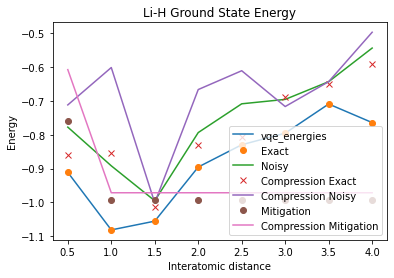

In [ ]:
print(distances)
print(hf_energies)

# pylab.plot(distances, hf_energies, label='Hartree-Fock')

pylab.plot(distances, exact_energies, label='vqe_energies')
pylab.plot(distances, exact_energies,'o', label='Exact')
pylab.plot(distances, noisy_vqe_energies,  label='Noisy')
# pylab.plot(distances, compression_exact_energies,'x', label='Compression Exact')
pylab.plot(distances, compression_noisy_vqe_energies,'-', label='Compression Noisy')
pylab.plot(distances, noisy_mitigation_vqe_energies,'o', label='Mitigation')
pylab.plot(distances, compression_noisy_mitigation_vqe_energies, label='Compression Mitigation')
# compression_exact_energies = []
# compression_noisy_vqe_energies = []

pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Li-H Ground State Energy')
pylab.legend(loc='lower right')
pylab.savefig('nn')
